In [ ]:
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/content/comments/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/comments/sample_submission.csv
/content/comments/test_labels.csv
/content/comments/test.csv
/content/comments/train.csv


In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch as nn
from sklearn.model_selection import train_test_split
from torch.nn import Dropout, Linear

In [ ]:
train_data = '/content/comments/train.csv'
test_data = '/content/comments/test.csv'
labels = '/content/comments/test_labels.csv'
sample = '/content/comments/sample_submission.csv'
epochs = 2

In [ ]:
! pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

In [ ]:
SEED = 34

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

In [ ]:
train_data = pd.read_csv('/content/comments/train.csv')
test_data = pd.read_csv('/content/comments/test.csv')
labels = pd.read_csv('/content/comments/test_labels.csv')
sample = pd.read_csv('/content/comments/sample_submission.csv')
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
insult = train_data[train_data['insult'] == 1]
insult.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0


In [ ]:
# sprawdzenie czy są dane puste 
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
id              0
comment_text    0
dtype: int64


In [ ]:
# sprawdzenie ile danych należy do konkrentej klasy
train = train_data.drop(['id', 'comment_text'], axis = 1)
labels = train.sum()
counted_labels = pd.DataFrame(labels)
counted_labels.rename(columns = {0:'Counted comments'}, inplace = True)
counted_labels = counted_labels.sort_values('Counted comments', ascending = False)
counted_labels

,Counted comments
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


In [ ]:
counted_labels.index

Index(['toxic', 'obscene', 'insult', 'severe_toxic', 'identity_hate',
       'threat'],
      dtype='object')

In [ ]:
# klasy są mocno zróźnicowane, bardzo duża róznica pomiędzy komentarzami klasy 'threat', a 'toxic'

Text(0.5, 1.0, 'Liczba komentarzy należących do każdej z pięciu klas dla zbioru testowego')

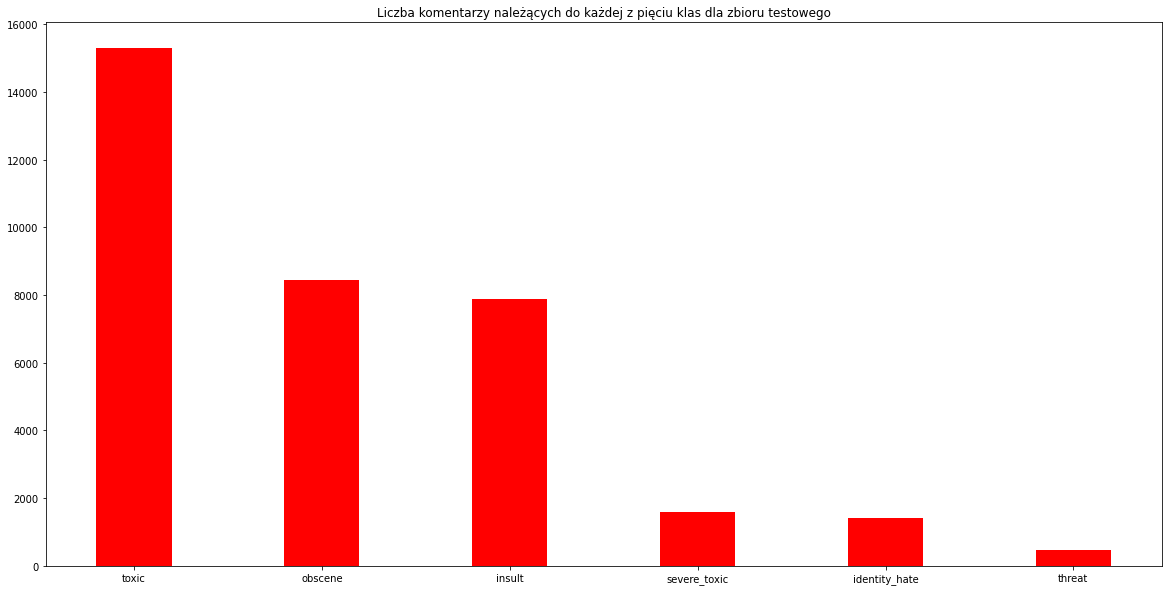

In [ ]:
fig = plt.subplots(figsize = (20,10))
plt.bar(counted_labels.index, counted_labels['Counted comments'], width=0.4, color='red')
plt.title("Liczba komentarzy należących do każdej z pięciu klas dla zbioru testowego")

In [ ]:
print(train_data.shape, test_data.shape)

(159571, 8) (153164, 2)


In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\<.*?\>', '', text)
    text = re.sub('\(.*?\)', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
text = re.sub('\[.*?\]', '', train_data['comment_text'][0])
text

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
train_data['clean_text'] = train_data['comment_text'].apply(str).apply(lambda x: clean_text(x))
test_data['clean_text'] = test_data['comment_text'].apply(str).apply(lambda x: clean_text(x))

In [ ]:
train_data['comment_text'][111]

In [ ]:
train_data['clean_text'][111]


## **1.BERT**

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from tokenizers import BertWordPieceTokenizer

In [ ]:
train1 = pd.read_csv("/content/comments/train.csv")
test = pd.read_csv('/content/comments/test.csv')
sub = pd.read_csv('/content/comments/sample_submission.csv')

In [ ]:
from sklearn.model_selection import train_test_split

x_t, x_v = train_test_split(train_data, train_size=0.8, random_state=32)
x_v, x_test_withlab = train_test_split(x_v, test_size=0.5, random_state=32)

In [ ]:
print(x_v.shape, x_t.shape, x_test_withlab.shape)

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding()
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
def create_output(predictions):
    probabilities = []
    for (i, prediction) in enumerate(predictions):
        preds = prediction["probabilities"]
        probabilities.append(preds)
    dff = pd.DataFrame(probabilities)
    dff.columns = LABEL_COLUMNS
    
    return dff

In [ ]:
x_t['clean_text'] = x_t['comment_text'].apply(str).apply(lambda x: clean_text(x))
x_v['clean_text'] = x_v['comment_text'].apply(str).apply(lambda x: clean_text(x))
test_data['clean_text'] = test_data['comment_text'].apply(str).apply(lambda x: clean_text(x))
x_test_withlab['clean_text'] = x_test_withlab['comment_text'].apply(str).apply(lambda x: clean_text(x))

In [ ]:
#IMP DATA FOR CONFIG
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
EPOCHS = 3
BATCH_SIZE = 16
MAX_LEN = 192

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:
x_train = fast_encode(x_t.clean_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(x_v.clean_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test_data.clean_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_testlabels = fast_encode(x_test_withlab.clean_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

#tutaj osobno dla każdej z klas
y_train = x_t.toxic.values
y_valid = x_v.toxic.values
y_testlabels = x_test_withlab.toxic.values

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

# test_dataset_withlab = (
#     tf.data.Dataset
#     .from_tensor_slices((x_testlabels, y_testlabels))
#     .batch(BATCH_SIZE)
# )

In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
transformer_layer = (
        transformers.TFDistilBertModel #tu można inne modele 
        .from_pretrained('distilbert-base-multilingual-cased')
    )
model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = 1000
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = model.predict(x_testlabels)

In [ ]:
threshold = 0.4
prediction_list = []
for prediction in y_pred: 
  if prediction[0] >= threshold: 
    prediction_list.append(1)
  else: 
    prediction_list.append(0)

In [ ]:
accuracy = accuracy_score(y_testlabels, prediction_list) 
conf_matrix = confusion_matrix(y_testlabels, prediction_list)
report = classification_report(y_testlabels, prediction_list)

In [ ]:
print(accuracy)
print(conf_matrix)
print(report) 

In [ ]:
model_accuracy = train_history.history["accuracy"]
model_loss = train_history.history["loss"]
model_val_accuracy = train_history.history["val_accuracy"]
model_val_loss = train_history.history["val_loss"]


In [ ]:
print(model_accuracy, model_loss, model_val_accuracy, model_val_loss)

In [ ]:
plt.title("Zmiana dokładności w trakcie treningu")
figure_acc.set_xlabel('epoka')
figure_acc.set_ylabel('miara - dokładność')
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.legend(['dane treningowe', 'dane walidacyjne'])

plt.show()

In [ ]:
plt.title("Zmiana parametru loss w trakcie treningu")
figure_acc.set_xlabel('epoka')
figure_acc.set_ylabel('miara - dokładność')
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['dane treningowe', 'dane walidacyjne'])

plt.show()